<a href="https://colab.research.google.com/github/RichardMWarburton/ExploringCUAD/blob/Exporatory-Analysis/Exploratory%20Data%20Analysis%20-%20PART%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis - PART 2

## The Data

CUAD: An Expert-Annotated NLP Dataset for Legal Contract Review

https://arxiv.org/abs/2103.06268

This code is an adaptation of the scrape.py file avaliable on the github repository for CUAD.  It has been adapted to run in Jypter notebooks and allow us to step throght the coding line by line.`

## Import Packages

In [1]:
from zipfile import ZipFile
import json
import os
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import re
from random import sample, choice
import numpy as np
import pandas as pd

## Download repository and extract data

In [2]:
def extract_zip(pth,data_pth = None):
    """Function to extract contents of a zip file to a specified location (wd if data_pth not passed)"""
    with ZipFile(pth, 'r') as zipObj:
       # Extract all the contents of zip file in different directory
       zipObj.extractall(data_pth)

In [3]:
#Download CUAD git repository
if not os.path.exists('main.zip'):
  !wget --no-check-certificate https://github.com/TheAtticusProject/cuad/archive/refs/heads/main.zip
  !unzip -q main.zip

#If it has not already been extracted, extract the contents of data.zip
if not os.path.exists('cuad-main/data'):
  os.makedirs('cuad-main/data')

if not os.path.exists('cuad-main/data/CUADv1.json'):
  extract_zip('cuad-main/data.zip','cuad-main/data/')

#Download a manualy curated set of labels for the full CUAD data. 
if not os.path.exists('labels3.txt'):
  !wget https://raw.githubusercontent.com/RichardMWarburton/ExploringCUAD/Exporatory-Analysis/labels3.txt

In [4]:
#Load CUADv1 JSON to data
with open('cuad-main/data/CUADv1.json','r') as infile:
    for line in infile:
        contract_data = json.loads(line)

## Read in Label Data & Generate Look Up Dictionary

In [5]:
#Initate storage for labels look up (LU)
labels_LU = {}

#Read in labels data
with open('labels3.txt','r',encoding ='UTF-8') as infile:
  for line in infile:
    #Remove trailing special characters and split on tab
    data = line.strip().split(sep='\t')
    #Add name and label to labels_LU dictionary
    labels_LU[data[0]] = data[1]

The look up returns one error, most likely due to the accented E and a disparity of encoding.  This will be forced to 'Marketing Agreement' manually for now (EITHER SORT OR PROVIDE EXAMPLE)

## Extract Raw Contract Data

In [6]:
#Set number of contracts in data
num_contracts = len(contract_data['data'])

#Initate dictionary to store raw contract data
raw_contracts = defaultdict(list)

#for each contract
for i in range(num_contracts):
  #Append the title, contract text and character length of text to the raw_contracts dictionary
  raw_contracts['contract title'].append(contract_data['data'][i]['title'])
  raw_contracts['label'].append(labels_LU[contract_data['data'][i]['title']] if contract_data['data'][i]['title'] in labels_LU else 'marketing agreement' ) #<- manual error trap applied here (see below)
  raw_contracts['contract text'].append(contract_data['data'][i]['paragraphs'][0]['context'])
  raw_contracts['contract text len'].append(len(contract_data['data'][i]['paragraphs'][0]['context']))


In [7]:
#Sanity check value lists for each key ahve the correct length (510)
for key in raw_contracts:
  print(key,len(raw_contracts[key]))

contract title 510
label 510
contract text 510
contract text len 510


## Extract Clause Specific Data

In [9]:
#Define the number of clauses
num_clauses = 41

#initate dictioanry to store caluse data
clause_data = defaultdict(list)

#For each contract
for i in range(num_contracts):
  #for each clause
  for j in range(num_clauses):
    #for each found clause annotation
    for k in range(len(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'])): 
      #Add the contract title
      clause_data['contract title'].append(contract_data['data'][i]['title'])
      clause_data['label'].append(labels_LU[contract_data['data'][i]['title']] if contract_data['data'][i]['title'] in labels_LU else 'marketing agreement' )  #<- manual error trap applied here
      clause_data['clause'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['id'].split(sep='__')[1])
      clause_data['annotation'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['text'])
      clause_data['annotation start'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['answer_start'])
      clause_data['annotation length'].append(len(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['text']))


In [10]:
#Sanity check value lists for each key ahve the correct length (13823)
for key in clause_data:
  print(key,len(clause_data[key]))

contract title 13823
label 13823
clause 13823
annotation 13823
annotation start 13823
annotation length 13823


## Summary Analysis

### Types of Conrtact

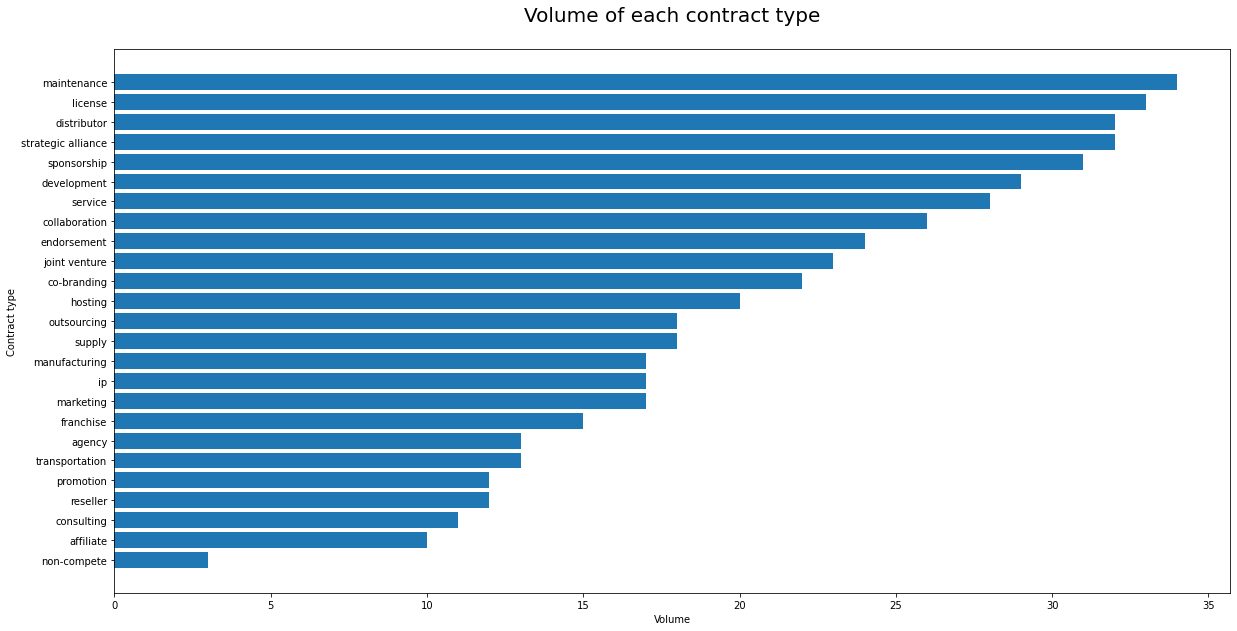

In [39]:
#Count types of contracts
contract_type_count = Counter(raw_contracts['label'])

#Extract raw count values and sort
counts = np.array(list(contract_type_count.values()))
idx = np.argsort(counts)

#Numpy function to strip 'agreements' from each label
vf = np.vectorize(lambda x: x.replace(' agreement', ''))

#re order counts by idx order and define coresponding labels
counts = counts[idx]
labs = np.array(vf(list(contract_type_count.keys()))[idx])

#Plot frequency of each contract type
plt.figure(figsize=(20,10))
plt.barh(labs,counts)
plt.title('Volume of each contract type\n',size =20)
plt.xlabel('Volume')
plt.ylabel('Contract type')
plt.show()

### Clause Count

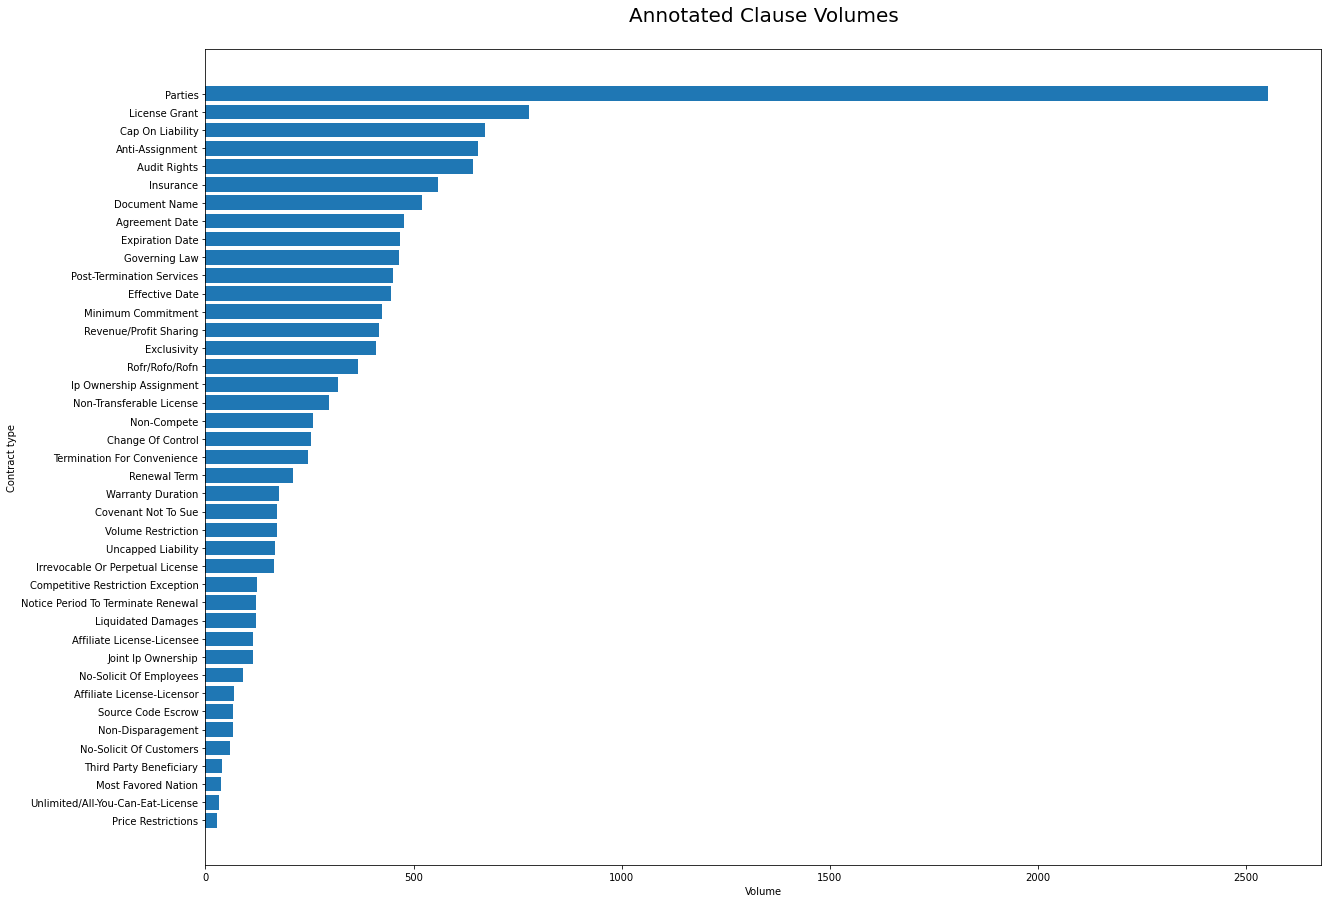

In [57]:
#Count types of contracts
clause_type_count = Counter(clause_data['clause'])

#Extract raw count values and sort
counts = np.array(list(clause_type_count.values()))
idx = np.argsort(counts)

#re order counts by idx order and define coresponding labels
counts = counts[idx]
labs = np.array(list(clause_type_count.keys()))[idx]

#Plot frequency of each contract type
plt.figure(figsize=(20,15))
plt.barh(labs,counts)
plt.title('Annotated Clause Volumes\n',size =20)
plt.xlabel('Volume')
plt.ylabel('Contract type')
plt.show()

### Clauses Per Contract

In [44]:
#Count types of contracts
clauses_per_contract = Counter(clause_data['contract title'])

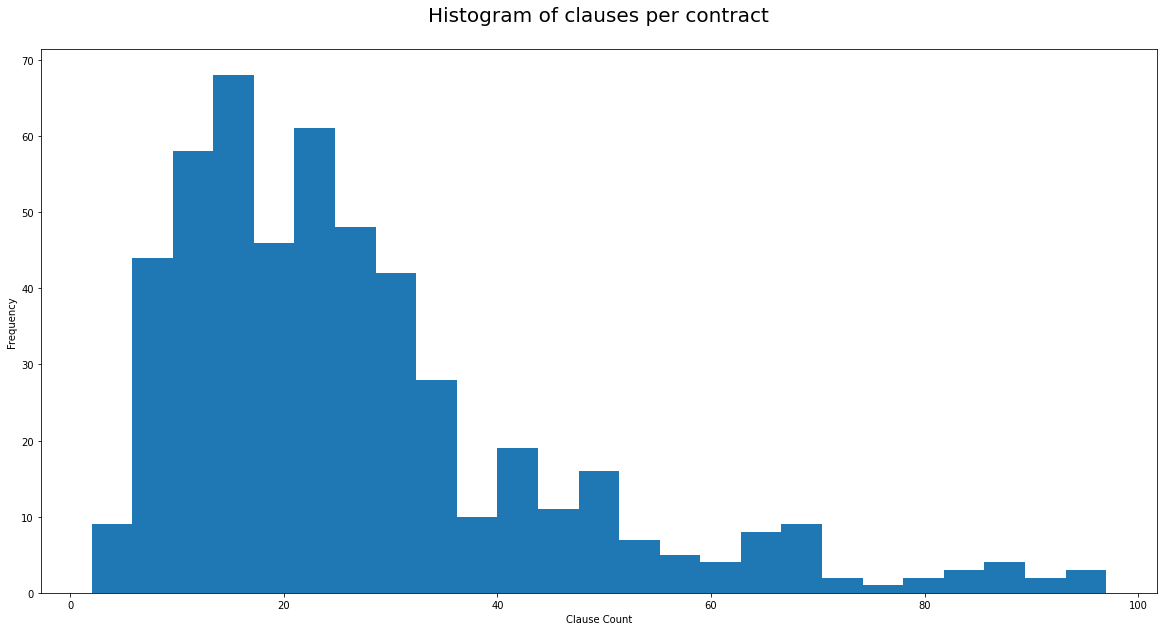

In [61]:
clause_counts = list(clauses_per_contract.values())

plt.figure(figsize =(20,10))
plt.title('Histogram of clauses per contract\n',size = 20)
plt.xlabel('Clause Count')
plt.ylabel('Frequency')
plt.hist(clause_counts,bins = 25)
plt.show()

### Relationship Between Contract Character Length and Clauses Annotated

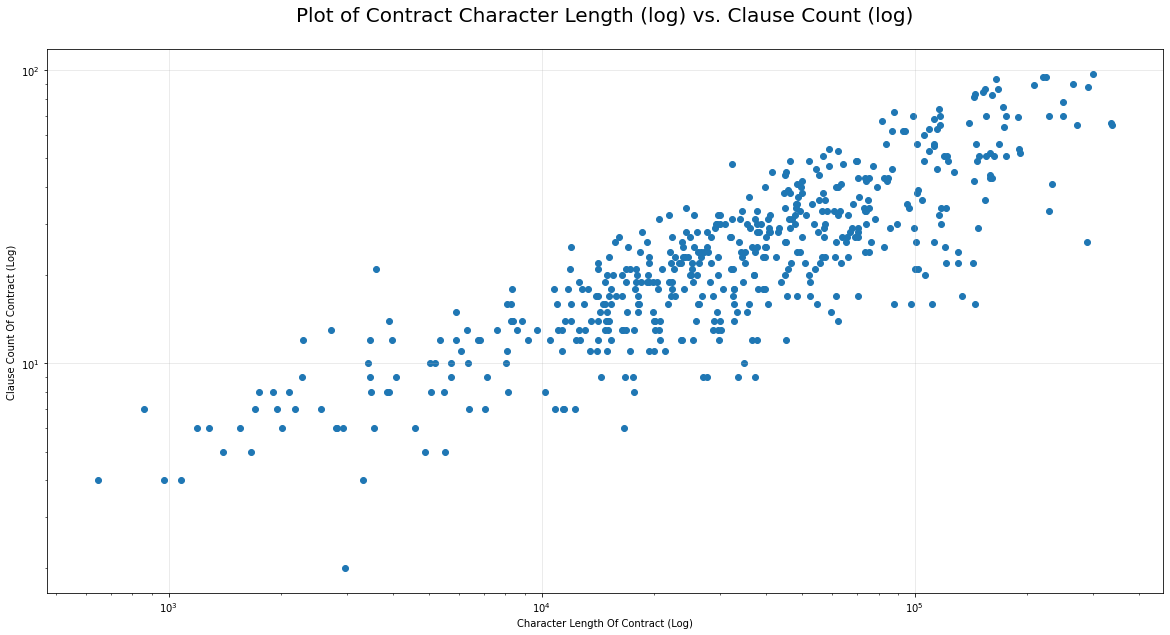

In [83]:
text_len = raw_contracts['contract text len']
clause_counts = [clauses_per_contract[x] for x in raw_contracts['contract title'] ]

plt.figure(figsize =(20,10))
plt.scatter(text_len,clause_counts)
plt.grid(alpha = 0.3)
plt.title('Plot of Contract Character Length (log) vs. Clause Count (log)\n', size = 20)
plt.xlabel('Character Length Of Contract (Log)')
plt.ylabel('Clause Count Of Contract (Log)')
plt.xscale('log')
plt.yscale('log')
plt.show()

### Similarity of Contracts Based On Shared Clauses

In [158]:
from sklearn.metrics import jaccard_score, pairwise_distances
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder


In [95]:
clause_lists = defaultdict(list)

for i in range(len(clause_data['clause'])):
  clause_lists[clause_data['contract title'][i]].append(clause_data['clause'][i])

In [188]:
contract_names = list(clause_lists.keys())
contract_clauses = list(clause_lists.values())

contract_labels = []
for x in contract_names:
  try:
    contract_labels.append(labels_LU[x])
  except:
    contract_labels.append('marketing agreement')

mlb = MultiLabelBinarizer()
le = LabelEncoder()

contract_clauses_set = ([set(x) for x in contract_clauses])
arr = mlb.fit_transform(contract_clauses_set)
clusters = le.fit_transform(contract_labels)

A = pairwise_distances(arr,arr,metric='jaccard')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [189]:
import networkx as nx
import matplotlib.colors as mcolors

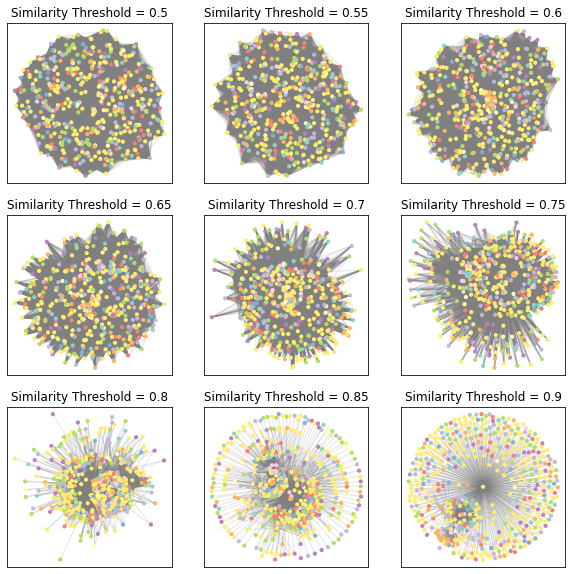

In [207]:
region = 330

plt.figure(figsize=(10,10))
#plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=1, hspace=0.01)

thresh_rng = [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]

for thresh in thresh_rng:
  AA = np.where(A>thresh,1,0)
  G = nx.from_numpy_matrix(AA)

  pos = nx.spring_layout(G) #<-- Set the spring layout
  region += 1

  plt.subplot(region)
  plt.title('Similarity Threshold = {}'.format(thresh))

  nodes = nx.draw_networkx_nodes(G,pos,node_size = 10,cmap = mcolors.ListedColormap(plt.cm.Set3(clusters)),node_color=list(clusters))
  edges = nx.draw_networkx_edges(G,pos,edge_color = 'grey',alpha = 0.2)

plt.show()